In [2]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pyserial
%pip install sympy
%pip install sounddevice

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# For "fast" real FFTs, length must be as follows:
# N=(2^a)*(3^b)*(5^c), a >= 1, b >=0, c >= 0

for a in range(1, 15):
    for b in range(0, 10):
        for c in range(0, 10):
            num = 2**a*3**b*5**c
            if num > 7500 and num < 8500:
                print(f"a{a}b{b}c{c}: {2**a*3**b*5**c}")


a2b4c2: 8100
a5b5c0: 7776
a6b0c3: 8000
a9b1c1: 7680
a13b0c0: 8192


In [4]:
from sympy import factorint

Fs = 48000
Ts = 1 / Fs
# White noise length
noise_dur_s = 0.2
# Nw = int(noise_dur_s * Fs )
Nw = 2**14
# Nw needs to be > 3000 (empirical tests)


# Rec length needs to be Nw + around 20m? worth of sample time
# (20m / 343 m/s) * 48000 = around 2800 samples
#record_len = Nw + 2800
record_len = Nw

valid_correlation_len = record_len - Nw + 1
# length of noise will be padded with zeros to get the same size (to make the multiplication in FFT domain possible)

# For FFT using the pffft library, length must round as follows:
# N=(2^a)*(3^b)*(5^c), a >= 5, b >=0, c >= 0 (32, 48, 64, 96, 128, 144, 160, etc are all acceptable lengths)
factors = factorint(record_len)
print(factors)
assert 2 in factors
assert factors[2] >= 5
factors.pop(2, None)
factors.pop(3, None)
factors.pop(5, None)
assert len(factors) == 0

{2: 14}


0.3563226983497898 0.3362882204186557 0.3519713957073137 0.3780837338328558


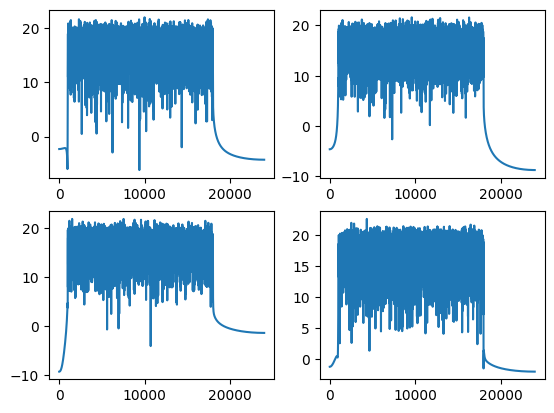

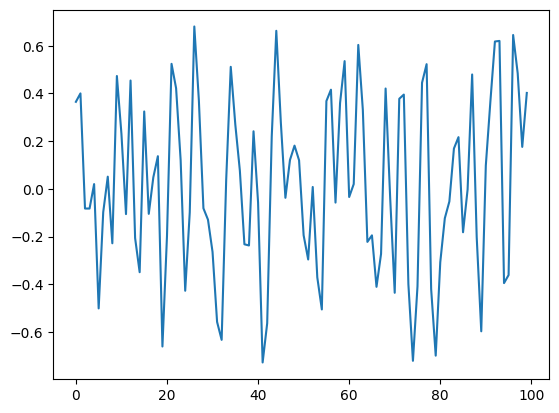

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# FIR filter
filter_order = 10000
cutoffs = [1000, 18000]
carrier_freq = cutoffs[0] + (cutoffs[1] - cutoffs[0]) / 2
# cutoffs = [1000, 10000]
# fir_coeff = sp.signal.firwin(filter_order, cutoffs[0], pass_zero='highpass', window='hann', fs=Fs)
# sos_filt = sp.signal.cheby2(filter_order, 100, cutoffs[0], btype='highpass', fs=Fs, output='sos')
fir_coeff = sp.signal.firwin(
    filter_order-1, cutoffs, pass_zero="bandpass", window="hann", fs=Fs
)
# sp.signal.freqz(fir_coeff, plot=lambda w, h: plt.plot(w*Fs/np.pi/2, 10 * np.log10(np.abs(h))))
# plt.show()


## Generate noise
def make_noise(seed):
    rng = np.random.default_rng(seed)
    white_noise = rng.normal(size=filter_order+Nw-2)
    # white_noise = rng.uniform(-1, 1, size=Nw)
    # white_noise = rng.integers(-1, 2, size=Nw)
    # white_noise = rng.integers(2, size=Nw)*2 - 1
    # white_noise = np.cbrt(rng.uniform(-1, 1, size=Nw))
    # plot filter

    # Applying the FIR filter to the white noise
    filtered_noise = sp.signal.convolve(white_noise, fir_coeff, mode="valid")
    # filtered_noise = sp.signal.sosfilt(sos_filt, white_noise)
    assert(len(filtered_noise) == Nw)

    filtered_noise /= max(filtered_noise)

    # plot noise
    noise_fft = sp.fft.rfft(filtered_noise)
    n = len(noise_fft)
    f = np.arange(n) * Fs / n / 2
    plt.plot(f, 10 * np.log10(np.abs(noise_fft)))

    return filtered_noise


## Generate noise
def make_noise2(seed):
    rng = np.random.default_rng(seed)
    t = np.arange(filter_order+Nw-2) * Ts
    #white_noise = np.cos(2 * np.pi * carrier_freq * t + rng.uniform(size=Nw, low=0, high=2*np.pi))
    white_noise = np.cos(2 * np.pi * carrier_freq * t + rng.normal(size=filter_order+Nw-2, scale=2*np.pi))
    # white_noise = rng.uniform(-1, 1, size=Nw)
    # white_noise = rng.integers(-1, 2, size=Nw)
    # white_noise = rng.integers(2, size=Nw)*2 - 1
    # white_noise = np.cbrt(rng.uniform(-1, 1, size=Nw))
    # plot filter

    # Applying the FIR filter to the white noise
    #filtered_noise = white_noise
    filtered_noise = sp.signal.convolve(white_noise, fir_coeff, mode="valid")
    assert(len(filtered_noise) == Nw)
    # filtered_noise = sp.signal.sosfilt(sos_filt, white_noise)

    filtered_noise /= max(filtered_noise)
    # plot noise
    noise_fft = sp.fft.rfft(filtered_noise)
    # noise_fft = sp.fft.rfft(white_noise)
    n = len(noise_fft)
    f = np.arange(n) * Fs / n / 2
    plt.plot(f, 10 * np.log10(np.abs(noise_fft)))

    return filtered_noise

plt.figure()
plt.subplot(221)
filtered_noiseA = make_noise2(4)
plt.subplot(222)
filtered_noiseB = make_noise2(9)
plt.subplot(223)
filtered_noiseC = make_noise2(100)
plt.subplot(224)
filtered_noiseD = make_noise2(1231)
assert len(filtered_noiseA) == Nw
pow1 = np.sqrt(np.sum(np.power(filtered_noiseA, 2)) / len(filtered_noiseA))
pow2 = np.sqrt(np.sum(np.power(filtered_noiseB, 2)) / len(filtered_noiseB))
pow3 = np.sqrt(np.sum(np.power(filtered_noiseC, 2)) / len(filtered_noiseC))
pow4 = np.sqrt(np.sum(np.power(filtered_noiseD, 2)) / len(filtered_noiseD))
print(pow1, pow2, pow3, pow4)
plt.figure()
plt.plot(filtered_noiseA[-700:-600])

In [6]:
np.save("filtered_noiseA.npy", filtered_noiseA)
np.save("filtered_noiseB.npy", filtered_noiseB)
np.save("filtered_noiseC.npy", filtered_noiseC)
np.save("filtered_noiseD.npy", filtered_noiseD)

In [7]:
for (letter, noise) in [('A', filtered_noiseA), ('B', filtered_noiseB), ('C', filtered_noiseC), ('D', filtered_noiseD)]:
    with open(f"../pico_play_noise/src/sound_samples/sound_samples{letter}.h", "w") as f:
        noise = np.copy(noise)
        noise *= 2**15-1
        noise = np.asarray(noise, dtype='uint16')
        hexed = [f"0x{sample:04X}" for sample in noise]
        f.write("#include <stddef.h> // for size_t\n")
        f.write("#include <stdint.h> // for uint16_t\n")
        f.write("\n")
        f.write(f"#define SOUND_SAMPLES_LEN {len(hexed)}\n")
        f.write("\n")
        f.write("//These are actually signed ints \n")
        f.write("const uint16_t sound_samples[SOUND_SAMPLES_LEN] = {\n")
        for window in range(0, len(hexed), 10):
            s = "    " + ", ".join(hexed[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")


In [8]:
for (i, noise) in enumerate([filtered_noiseA, filtered_noiseB, filtered_noiseC, filtered_noiseD]):
    with open(f"pico_fft_test/src/sound_correlation/sound_correlation{i}.h", "w") as f:
        padded = np.pad(noise, (0, record_len-Nw), 'constant', constant_values=0)
        #padded *= 2**15-1
        #padded = np.asarray(padded, dtype='uint32')
        fft = np.fft.rfft(padded)
        #print(len(fft))
        conj = np.conj(fft)
        conj /= np.max(np.abs(conj))
        conj *= 2**15-1
        # length of RFFT is N/2+1 complex numbers
        # We interleave the real and imag
        # Thus we have N+2 nums
        interleaved = np.zeros(len(padded)+2, dtype='uint32') 
        interleaved[0::2] = np.asarray(conj.real, dtype='uint32')
        interleaved[1::2] = np.asarray(conj.imag, dtype='uint32')
        interleaved = [f"0x{f:08X}" for f in interleaved]
        
        f.write("#include <stddef.h> // for size_t\n")
        f.write("\n")
        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")
        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")
        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")
        f.write("\n")
        f.write(f"#define FFT_SIZE {record_len}\n")
        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")
        f.write("\n")
        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")
        f.write("const uint32_t sound_samples_fft_conj[CONV_BUFFER_SIZE] = {\n")
        for window in range(0, len(interleaved), 10):
            s = "    " + ", ".join(interleaved[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n") 

""" for (i, noise) in enumerate([filtered_noise, filtered_noise2, filtered_noise3, filtered_noise4]):
    with open(f"pico_fft_test/src/sound_correlation/sound_correlation{i}.h", "w") as f:
        padded = np.pad(noise, (0, record_len-Nw), 'constant', constant_values=0)
        padded *= 2**15-1
        padded = np.asarray(padded, dtype='uint32') << 6
        padded = [f"0x{sample:08X}" for sample in padded]
                
        f.write("#include <stddef.h> // for size_t\n")
        f.write("\n")
        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")
        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")
        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")
        f.write("\n")
        f.write(f"#define FFT_SIZE {record_len}\n")
        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")
        f.write("\n")
        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")
        f.write("uint32_t sound_samples_fft[CONV_BUFFER_SIZE] = {\n")
        for window in range(0, len(padded), 10):
            s = "    " + ", ".join(padded[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")  """


' for (i, noise) in enumerate([filtered_noise, filtered_noise2, filtered_noise3, filtered_noise4]):\n    with open(f"pico_fft_test/src/sound_correlation/sound_correlation{i}.h", "w") as f:\n        padded = np.pad(noise, (0, record_len-Nw), \'constant\', constant_values=0)\n        padded *= 2**15-1\n        padded = np.asarray(padded, dtype=\'uint32\') << 6\n        padded = [f"0x{sample:08X}" for sample in padded]\n                \n        f.write("#include <stddef.h> // for size_t\n")\n        f.write("\n")\n        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")\n        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")\n        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")\n        f.write("\n")\n        f.write(f"#define FFT_SIZE {record_len}\n")\n        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")\n        f.write("\n")\n        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")\n        f.write("uint32_t sound_samples_f

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def correlate_and_find_delay(rec, noise, name):
    # rec_padded = np.pad(rec, (len(noise), 0), 'constant', constant_values=0)
    # print(rec)
    rec_fft = np.fft.rfft(rec)
    diff = len(rec) - len(noise)
    assert diff == 0
    noise_padded = np.pad(noise, (0, diff), "constant", constant_values=0)
    noise_fft_conj = np.conj(np.fft.rfft(noise_padded))
    # print(rec_fft.shape, noise_fft_conj.shape)
    cross_corr_freq = noise_fft_conj * rec_fft
    cross_corr = np.abs(np.fft.irfft(cross_corr_freq))
    
    #valid_len = diff + 1
    #cross_corr = cross_corr[:valid_len]
    
    # print(cross_corr)
    plt.plot(cross_corr)
    plt.title("correlation " + name)

    k_max_ind = np.argmax(cross_corr)
    k_max = cross_corr[k_max_ind]
    avg = np.sum(cross_corr) / len(cross_corr)

    return k_max_ind, k_max, avg

indexes: 400 1000 1200 16184
maxes: 2117.6393682246285 1819.7013620699258 1959.8248774555088 2307.6129051648504
avgs: 31.104023146665405 29.405974764929667 31.009728143517627 32.76365616754186
max/avg: 68.08249075173596 61.88202828223022 63.20032437514925 70.43209382263464


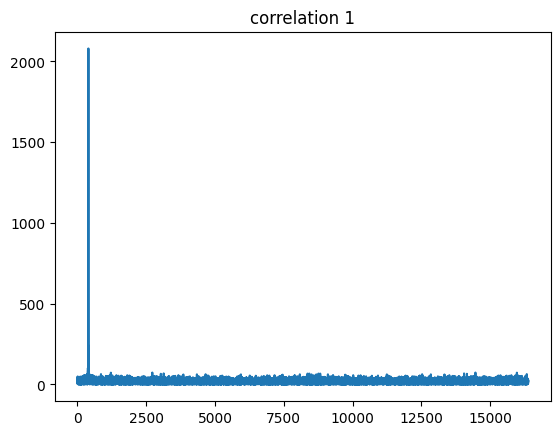

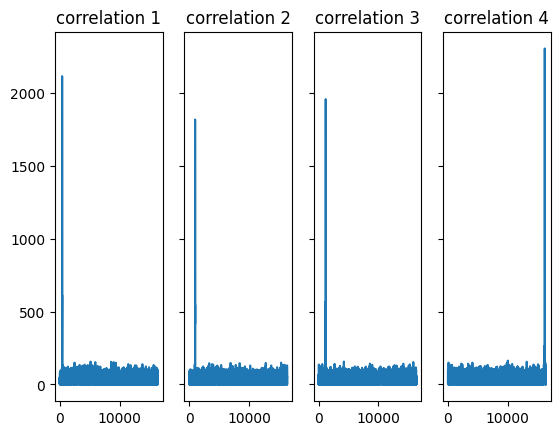

In [10]:
import numpy as np
import matplotlib.pyplot as plt

recording_noise_1 = np.zeros(record_len)
recording_noise_2 = np.zeros(record_len)
recording_noise_3 = np.zeros(record_len)
recording_noise_4 = np.zeros(record_len)

insert_loc = 400
# recording_noise_1[insert_loc : insert_loc + Nw] += filtered_noise1
recording_noise_1 = np.roll(filtered_noiseA, insert_loc)
insert_loc2 = 1000
# recording_noise_2[insert_loc2 : insert_loc2 + Nw] += filtered_noise2
recording_noise_2 = np.roll(filtered_noiseB, insert_loc2)
insert_loc3 = 1200
# recording_noise_3[insert_loc3 : insert_loc3 + Nw] += filtered_noise3
recording_noise_3 = np.roll(filtered_noiseC, insert_loc3)
insert_loc4 = Nw-200
# recording_noise_4[insert_loc4 : insert_loc4 + Nw] += filtered_noise4
recording_noise_4 = np.roll(filtered_noiseD, insert_loc4)

recording_noise_together = recording_noise_1 + recording_noise_2 + recording_noise_3 + recording_noise_4
# recording_noise_together = recording_noise_together / max(recording_noise_together)

plt.figure()
ind1 = correlate_and_find_delay(recording_noise_1, filtered_noiseA, "1")
plt.figure()
ax1 = plt.subplot(141)
ind1, max1, avg1 = correlate_and_find_delay(recording_noise_together, filtered_noiseA, "1")
plt.subplot(142, sharey=ax1)

ind2, max2, avg2 = correlate_and_find_delay(recording_noise_together, filtered_noiseB, "2")
plt.tick_params("y", labelleft=False)
plt.subplot(143, sharey=ax1)
ind3, max3, avg3 = correlate_and_find_delay(recording_noise_together, filtered_noiseC, "3")
plt.tick_params("y", labelleft=False)
plt.subplot(144, sharey=ax1)
ind4, max4, avg4 = correlate_and_find_delay(recording_noise_together, filtered_noiseD, "4")
plt.tick_params("y", labelleft=False)
print("indexes:", ind1, ind2, ind3, ind4)
print("maxes:", max1, max2, max3, max4)
print("avgs:", avg1, avg2, avg3, avg4)
print("max/avg:", max1/avg1, max2/avg2, max3/avg3, max4/avg4)

699
[5.000005   4.99999167] [-2.18873797e-03  6.66792680e+00]


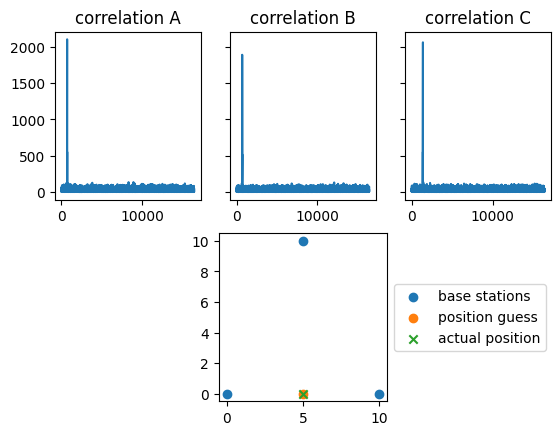

In [11]:
### Time Difference of Arrival with 3 nodes

A = np.array([0, 0])
B = np.array([10, 0])
C = np.array([5, 10])

actual_position = np.array([5, 0])

delay1 = int(abs(np.linalg.norm(A - actual_position)) * Fs // 343)
delay2 = int(abs(np.linalg.norm(B - actual_position)) * Fs // 343)
delay3 = int(abs(np.linalg.norm(C - actual_position)) * Fs // 343)

recording_noise = np.zeros(record_len)
print(delay1)
#recording_noise[delay1 : delay1 + Nw] += filtered_noise1
recording_noise += np.roll(filtered_noiseA, delay1)
#recording_noise[delay2 : delay2 + Nw] += filtered_noise2
recording_noise += np.roll(filtered_noiseB, delay2)
#recording_noise[delay3 : delay3 + Nw] += filtered_noise3
recording_noise += np.roll(filtered_noiseC, delay3)


def fangs_algorithm_TDoA(ta, tb, tc):
    ## Fang's algorithm, gotten from the PDF (in the repo or at https://ieeexplore.ieee.org/document/102710)
    assert A[0] == 0 and A[1] == 0
    assert B[0] > 0 and B[1] == 0
    assert C[1] > 0

    c = 343  # speed of wave in medium, speed of sound=343 m/s

    cTa = ta * c
    cTb = tb * c
    cTc = tc * c

    b = B[0]  # also = np.linalg.norm(B)
    cx = C[0]
    cy = C[1]
    c = np.linalg.norm(C)

    Rab = cTa - cTb
    Rac = cTa - cTc

    #avoid division by zero, just make em real small
    if Rab == 0.0:
        Rab = 1e-5
    if Rac == 0.0:
        Rac = 1e-5

    # variable names correspond to those in the paper

    g = (Rac * b / Rab - cx) / cy
    h = (c**2 - Rac**2 + Rac * Rab * (1 - (b / Rab) ** 2)) / (2 * cy)

    d = -(1 - (b / Rab) ** 2 + g**2)
    e = b * (1 - (b / Rab) ** 2) - 2 * g * h
    f = (Rab**2 / 4) * (1 - (b / Rab) ** 2) ** 2 - h**2

    z = 0
    x = np.roots([d, e, f - z**2])  # eq 9a
    y = g * x + h  # eq 13
    print(x, y)

    guess1 = np.array([x[0], y[0]])
    guess2 = np.array([x[1], y[1]])

    def err(g):
        # calculate what sort of time deltas would be seen with this guess
        # compare them to the original, return the MSE
        deltaA = np.linalg.norm(g - A)
        deltaB = np.linalg.norm(g - B)
        deltaC = np.linalg.norm(g - C)
        rab = deltaA - deltaB
        rac = deltaA - deltaC
        mse = ((rab - Rab) ** 2 + (rac - Rac) ** 2) / 2
        return mse

    best_guess = min([guess1, guess2], key=err)
    return best_guess


plt.figure()
ax1 = plt.subplot(231)
found_delay1, max1, avg1 = correlate_and_find_delay(recording_noise, filtered_noiseA, "A")
plt.subplot(232, sharey=ax1)
found_delay2, max2, avg2 = correlate_and_find_delay(recording_noise, filtered_noiseB, "B")
plt.tick_params('y', labelleft=False)
plt.subplot(233, sharey=ax1)
found_delay3, max3, avg3 = correlate_and_find_delay(recording_noise, filtered_noiseC, "C")
plt.tick_params('y', labelleft=False)

ta = found_delay1 / Fs
tb = found_delay2 / Fs
tc = found_delay3 / Fs

guessed_position = fangs_algorithm_TDoA(ta, tb, tc)
plt.subplot(212)
plt.scatter([A[0], B[0], C[0]], [A[1], B[1], C[1]], label="base stations", marker="o")
plt.scatter(guessed_position[0], guessed_position[1], label="position guess")
plt.scatter(actual_position[0], actual_position[1], label="actual position", marker="x")
plt.gca().set_aspect("equal")
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))

[]


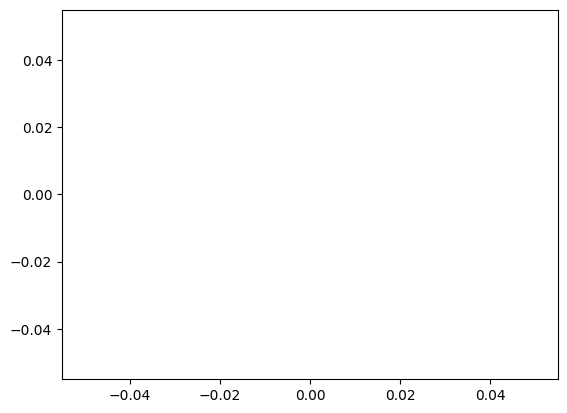

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

thing = """"""

y = thing.splitlines()
print(y)
y = [abs(int(s)) for s in y]

plt.plot(y)


In [13]:
import serial
import scipy as sp
import numpy as np 

fs, samples = sp.io.wavfile.read("song3.wav")
samples = samples // 8
print(fs, samples.dtype)
assert(samples.dtype == np.int16)
sample_bytes = samples.tobytes()

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(sample_bytes)
ser.flush()
print("done")

48000 int16


SerialException: [Errno 2] could not open port /dev/ttyACM1: [Errno 2] No such file or directory: '/dev/ttyACM1'

In [ ]:
import serial
import scipy as sp
import numpy as np 

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(b"r")
b = ser.read(48000 * 2 * 5)

#samples = np.frombuffer(b, dtype=np.uint32)
#samples = (samples)
#samples = np.frombuffer(samples.tobytes(), dtype=np.int32)
samples = np.frombuffer(b, dtype=np.int16)
import sounddevice as sd

sd.play(samples, 48000)
sd.wait()
for i in samples:
    print(hex(i))

In [ ]:
thing = """"""

ke = thing.splitlines()
ke = [a.split(" ") for a in ke]
ke = [int(a[0], 16) + 1j*int(a[1], 16) for a in ke]
print(np.max(np.abs(ke)))

In [ ]:
# Used with pico_record_noise, plays the sound samples as they are received
import serial
import sounddevice as sd



with serial.Serial("/dev/ttyACM0", 115200) as ser:
    # ser.set_buffer_size(rx_size = 8192)
    while True:
        line = ser.readline().strip()
        if line != b"bytes":
            if len(line) < 100:
                print(line)
            continue
        size = ser.readline().strip()
        size = int(size.decode("utf-8"))
        #print(size)
        b = ser.read(size)
        corr = np.frombuffer(b, dtype="<i2")
        sd.play(corr, 48000)
        sd.wait()
        #plt.plot(np.abs(corr))

In [15]:
import sounddevice as sd
import threading

event = threading.Event()

data = filtered_noiseA + filtered_noiseB + filtered_noiseC
data /= 3
data = np.pad(data, (0,Nw*1000), 'wrap').reshape(-1,1)


sd.play(data, samplerate=Fs, blocking=True, loop=False)

KeyboardInterrupt: 